# LSTM 

## Dependencies

In [1]:
# essentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# warnings
import warnings
warnings.filterwarnings('ignore')

# local
import utils

# model
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn

## Data Preparation

Using the cutoff version of the dataset

In [2]:
df = utils.get_time_series_1()
df = utils.z_score_outlier(df, 2)

          ds          y
0 2012-03-02  137233.99
1 2012-03-03  190247.55
2 2012-03-04  197809.12
3 2012-03-05  125417.64
4 2012-03-06  120953.92
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      364 non-null    datetime64[ns]
 1   y       364 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB
None
Dropping 12 rows.


In [3]:
# Scale the data
data = df['y'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

cutoff = round(len(scaled_data) * 0.8)
scaled_train = scaled_data[:cutoff]
scaled_test = scaled_data[cutoff:]

#### Organised for LSTM

In order to train and predict the next day the lstm needs a certain window as data for input. So whatever the time_step variable is (say 30), the data has to be organised into tensors of length 30. 

Example:
[x1, x2, ... x30]
[x2, x3, ... , x31]

In [4]:
def prepare_data(scaled_data, time_step):
    # Create sequences
    X, y = [], []
    for i in range(time_step, len(scaled_data)):
        X.append(scaled_data[i - time_step:i, 0])
        y.append(scaled_data[i, 0])

    # Convert to numpy arrays and then to torch tensors
    X = np.array(X)
    y = np.array(y)
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).float()

    X = X.view(-1, time_step, 1)

    return X, y

## Define LSTM model

In [5]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=20, num_layers=2, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_() #short
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_() #long
        out, _ = self.lstm(x, (h0, c0))
        out = self.linear(out[:, -1, :])  # Take the last time step's output
        return out

## Setup to train, test, and evaluate model

In [8]:
def train_model(X_train, y_train, epochs=10, lr=0.001):

    model = LSTM()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    errors = []

    for epoch in range(epochs):
        model.train()
        outputs = model(X_train)
        optimizer.zero_grad()

        loss = criterion(outputs, y_train.view(-1, 1))
        errors.append(loss.item())
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
    return model, errors

In [9]:
def make_predictions(model, X_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        predictions = scaler.inverse_transform(predictions.numpy())
    return predictions

In [10]:
def plot_predictions(predictions, y_test, time_step):
    plt.figure(figsize=(10,6))
    plt.plot(predictions, label="Predictions")
    plt.plot(y_test, label="y_test")
    plt.show()

#### RUN THIS ####

Epoch [1/500], Loss: 0.1754
Epoch [11/500], Loss: 0.1055
Epoch [21/500], Loss: 0.0660
Epoch [31/500], Loss: 0.0582
Epoch [41/500], Loss: 0.0582
Epoch [51/500], Loss: 0.0573
Epoch [61/500], Loss: 0.0573
Epoch [71/500], Loss: 0.0571
Epoch [81/500], Loss: 0.0571
Epoch [91/500], Loss: 0.0570
Epoch [101/500], Loss: 0.0570
Epoch [111/500], Loss: 0.0570
Epoch [121/500], Loss: 0.0570
Epoch [131/500], Loss: 0.0569
Epoch [141/500], Loss: 0.0569
Epoch [151/500], Loss: 0.0569
Epoch [161/500], Loss: 0.0568
Epoch [171/500], Loss: 0.0568
Epoch [181/500], Loss: 0.0567
Epoch [191/500], Loss: 0.0567
Epoch [201/500], Loss: 0.0566
Epoch [211/500], Loss: 0.0565
Epoch [221/500], Loss: 0.0565
Epoch [231/500], Loss: 0.0563
Epoch [241/500], Loss: 0.0562
Epoch [251/500], Loss: 0.0561
Epoch [261/500], Loss: 0.0559
Epoch [271/500], Loss: 0.0556
Epoch [281/500], Loss: 0.0552
Epoch [291/500], Loss: 0.0547
Epoch [301/500], Loss: 0.0538
Epoch [311/500], Loss: 0.0523
Epoch [321/500], Loss: 0.0495
Epoch [331/500], Loss

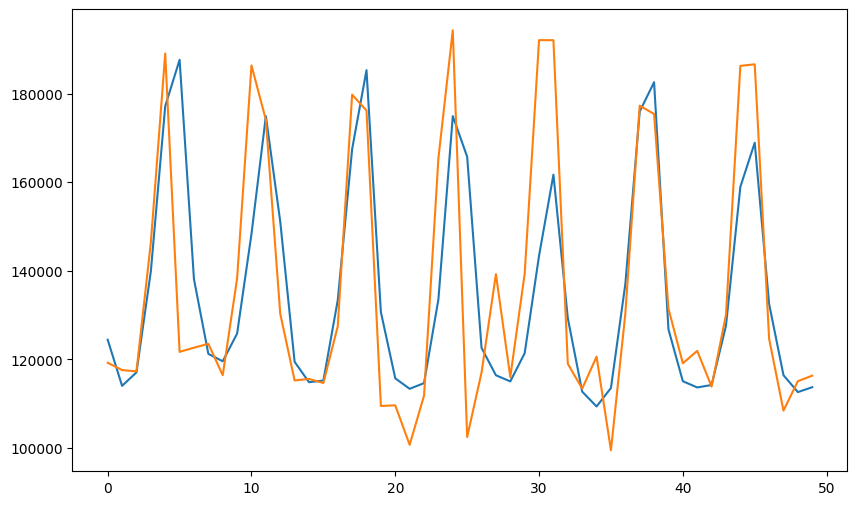

MAPE score = 14.78
MAPE score last 90 = 8.88


In [11]:
time_step = 20

X_train, y_train = prepare_data(scaled_train, time_step)

X_test, y_test = prepare_data(scaled_test, time_step)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

lr = 0.001 
epochs = 500

model, errors = train_model(X_train, y_train, epochs, lr)

print('-'*80)

predictions = make_predictions(model, X_test)

plot_predictions(predictions, y_test, time_step)

mape_score_all = utils.mape(predictions[time_step:], y_test[time_step])
mape_score_comp = utils.mape(predictions, y_test)

print(f"MAPE score = {mape_score_all}")
print(f"MAPE score last 90 = {mape_score_comp}")

### Hyperparameter selection

Plotting the loss against epochs. 
- Look at how many epochs you should run it for
- If the loss has a smooth decline you have a good lr. To little or to much = to large or to small lr

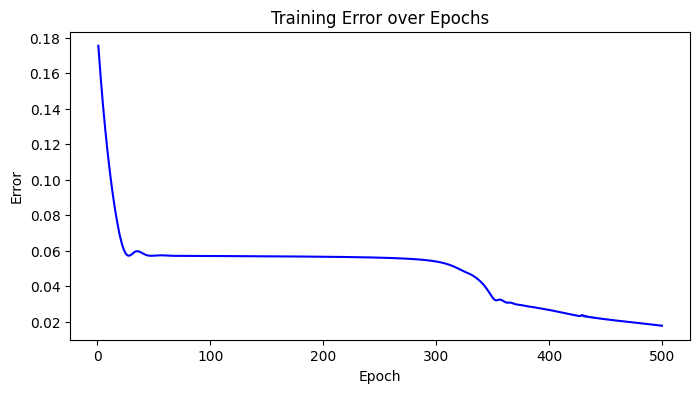

In [12]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, epochs+1), errors, label="Training Error", color="b")

plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Training Error over Epochs")

plt.show()

## Store results

In [13]:

### STORE RESULTS ###
import os
from datetime import datetime

comment = """
weight_decay=1e-4, train/test
"""

file_path = 'data/lstm_results.csv'
file_exists = os.path.isfile(file_path)

columns = ["datetime", "time_step", "hidden_size", "learning_rate", "epochs", "mape", "mape_last_90", "comment"]

new_row = {
    "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "time_step": time_step,
    "hidden_size": model.hidden_size,
    "learning_rate": lr,
    "epochs": epochs,
    "mape": mape_score_all,
    "mape_last_90": mape_score_comp,
    "comment": comment
}

if not file_exists:
    df = pd.DataFrame([new_row], columns=columns)
    df.to_csv(file_path, index=False)
else:
    df = pd.DataFrame([new_row], columns=columns)
    df.to_csv(file_path, mode='a', header=False, index=False)

print(f'Results saved to {file_path}')

Results saved to lstm_results.csv


In [14]:
results = pd.read_csv(file_path)
results

,datetime,time_step,hidden_size,learning_rate,epochs,mape,mape_last_90,comment
0,2024-11-05 13:24:42,20,20,0.001,500,14.78,8.88,"\nweight_decay=1e-4, train/test\n"
